# Practical Bayesian Optimization

## 0. Env

#### Imports

In [41]:
import os
import time
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.exceptions import ConvergenceWarning

In [42]:
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [43]:
pl.Config.set_fmt_str_lengths(90)

polars.config.Config

#### Constants

In [44]:
home = "../.."
images_dir = os.path.join(home, "static/images/")

In [45]:
TRAIN_TEST_SPLIT_FRACTION = 0.8
MODEL_TARGET = "price_log10"

## 1. Load Data

#### Load data for New York City

In [46]:
df_query = (
    pl.scan_csv("../data/miami-housing.csv")
    .with_columns([
        pl.col("SALE_PRC").alias("price"),
        pl.col(["LATITUDE", "LONGITUDE"]).name.to_lowercase()
    ])
    .select(pl.col(["latitude", "longitude", "price"]))
    .with_columns((pl.col("price")).log10().name.suffix("_log10"))
)

In [47]:
num_rows = df_query.collect().shape[0]
df = (
    df_query.collect()
    .sample(fraction=1, shuffle=True)
    .with_row_index(name="row_number")
    .with_columns([
        (pl.col("row_number") < TRAIN_TEST_SPLIT_FRACTION * num_rows).alias("is_train")
    ])
)

#### Viewing the data

In [48]:
display(df.count())

row_number,latitude,longitude,price,price_log10,is_train
u32,u32,u32,u32,u32,u32
13932,13932,13932,13932,13932,13932


In [49]:
display(
    df
    .head()
)

row_number,latitude,longitude,price,price_log10,is_train
u32,f64,f64,f64,f64,bool
0,25.841216,-80.223898,150000.0,5.176091,true
1,25.621647,-80.317787,900000.0,5.954243,true
2,25.890744,-80.355169,276000.0,5.440909,true
3,25.81527,-80.227369,115000.0,5.060698,true
4,25.781297,-80.400291,288000.0,5.459392,true


## 2. Brief EDA

#### Distribution of Prices

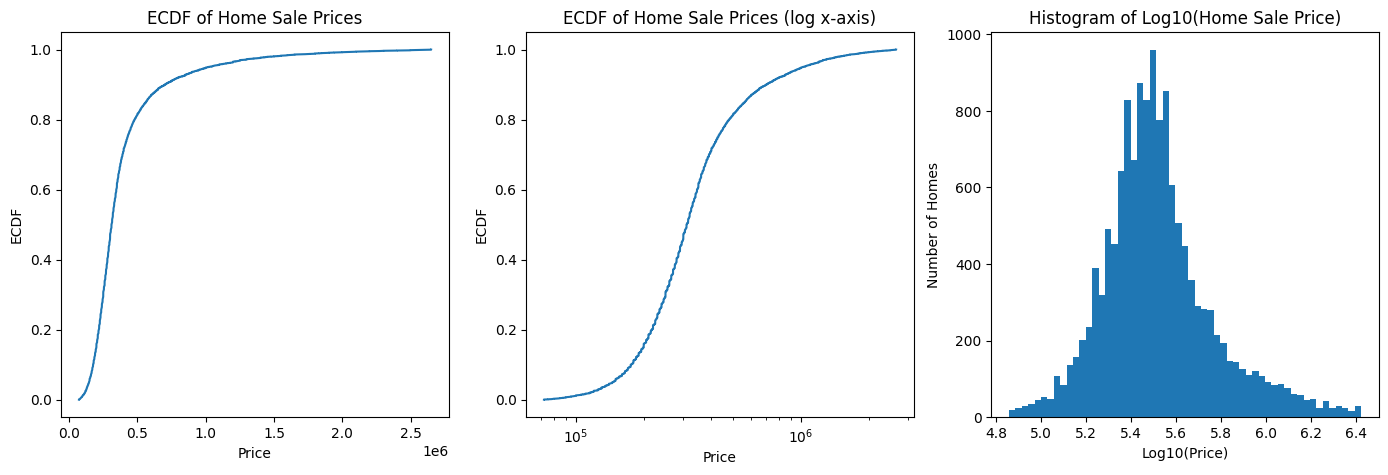

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax1.set_xlabel("Price")
ax1.set_ylabel("ECDF")
ax1.set_title("ECDF of Home Sale Prices")

ax2.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax2.set_xscale("log")
ax2.set_xlabel("Price")
ax2.set_ylabel("ECDF")
ax2.set_title("ECDF of Home Sale Prices (log x-axis)")

ax3.hist(df["price_log10"], bins=55, density=False)
ax3.set_xlabel("Log10(Price)")
ax3.set_ylabel("Number of Homes")
ax3.set_title("Histogram of Log10(Home Sale Price)")

plt.savefig(os.path.join(images_dir, "distribution-of-home-sale-price.png"))

#### Distribution over Space

In [51]:
df.select(["latitude", "longitude", "price"]).corr()

latitude,longitude,price
f64,f64,f64
1.0,0.721232,0.047701
0.721232,1.0,0.195274
0.047701,0.195274,1.0


## 3. Hyperparameter Optimization

### 3.0 Setup

In [52]:
X_train = df.filter(pl.col("is_train"))
y_train = df.filter(pl.col("is_train"))
X_test = df.filter(~pl.col("is_train"))
y_test = df.filter(~pl.col("is_train"))

In [53]:
MODEL_FEATURE_LIST_NAME = "raw_lat_lon"
MODEL_FEATURE_LIST = ["latitude", "longitude"]

### 3.1. Bayes Optimization

In [54]:
def plot_prediction_surface(grid, y_mean, y_std, duration_mean, duration_std, acquisition_function):
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    ax[0].plot(grid, y_mean, "r", label="Expected Value of Model Performance")
    ax[0].fill_between(grid.reshape(-1), y_mean - y_std, y_mean + y_std, alpha=0.1, color="black", label="± 1 std dev")
    ax[0].plot(grid, duration_mean, "orange", label="Expected Duration of Model Evaluation")
    ax[0].plot(grid, acquisition_function, "black", label="Acquisition Function")
    ax[0].set_xlabel("n_estimators")
    ax[0].legend()
    ax[1].plot(grid, duration_mean, "r", label="Expected Value of Model Performance")
    ax[1].fill_between(
        grid.reshape(-1),
        duration_mean - duration_std,
        duration_mean + duration_std,
        alpha=0.1,
        color="black",
        label="± 1 std dev"
    )
    
    plt.show()

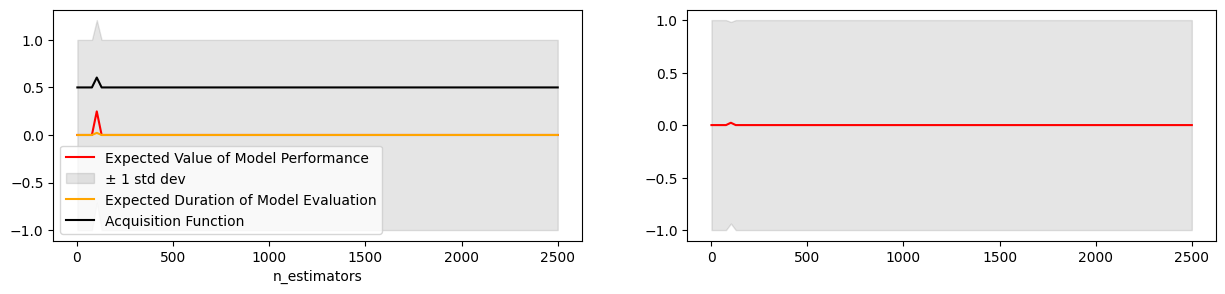

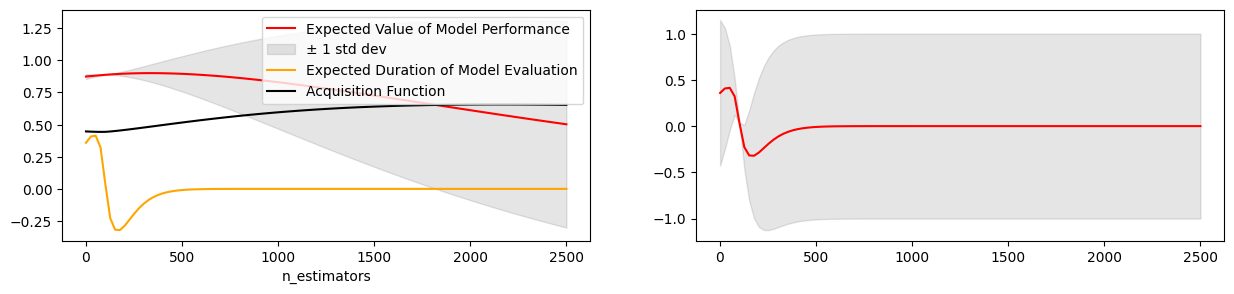

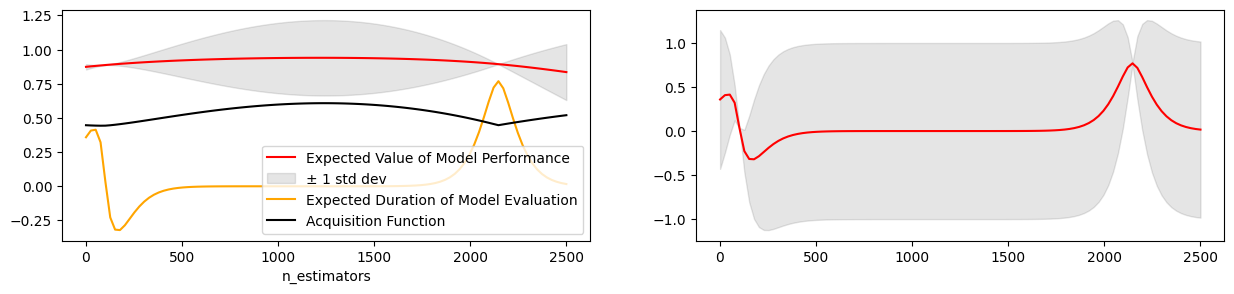

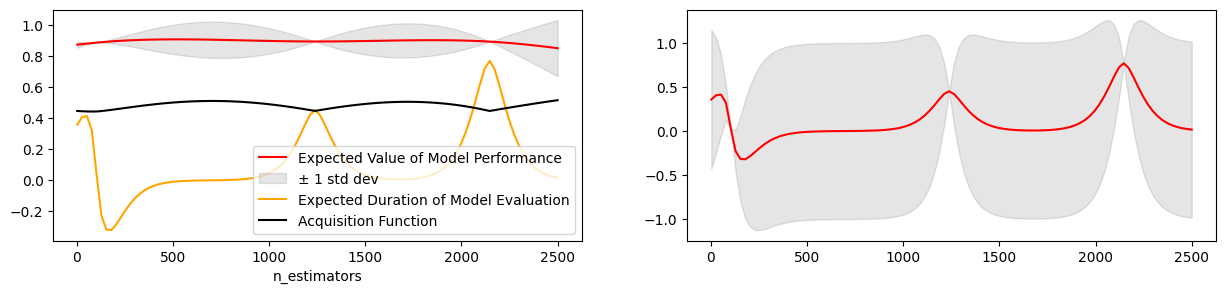

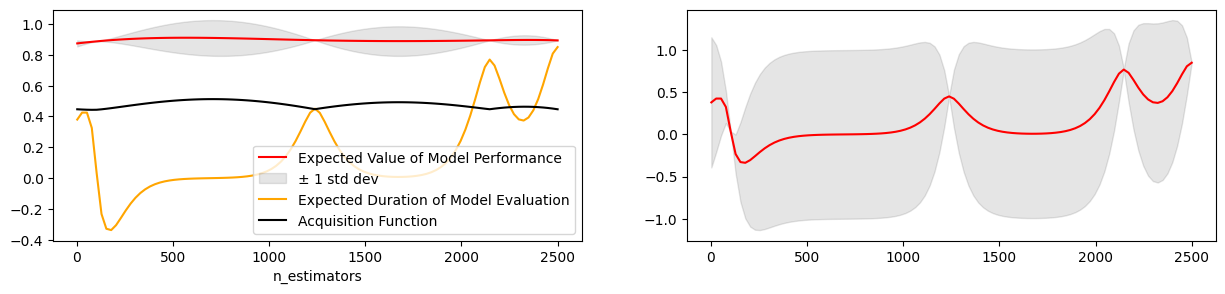

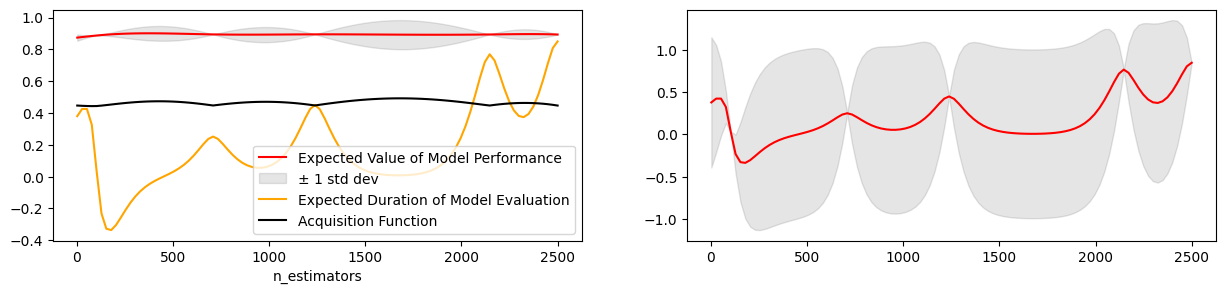

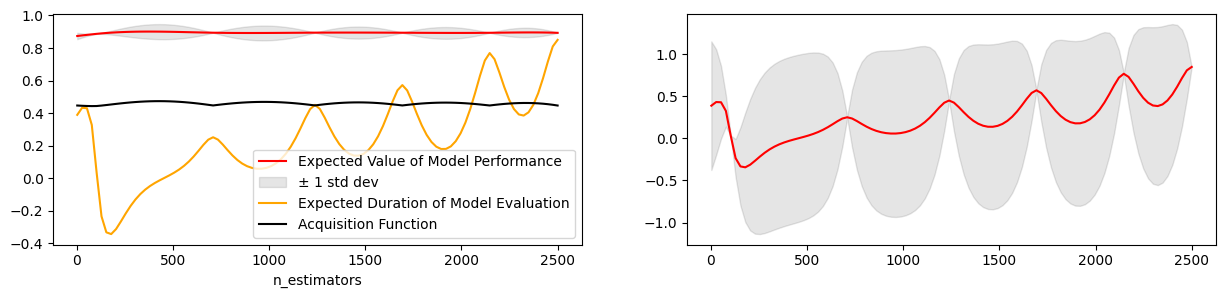

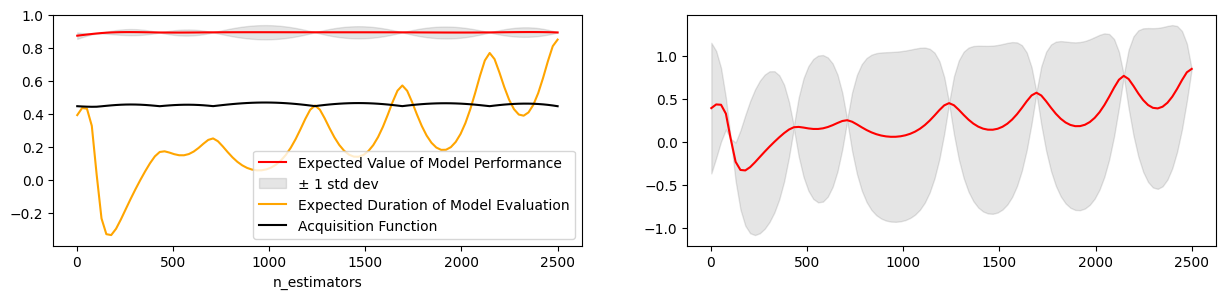

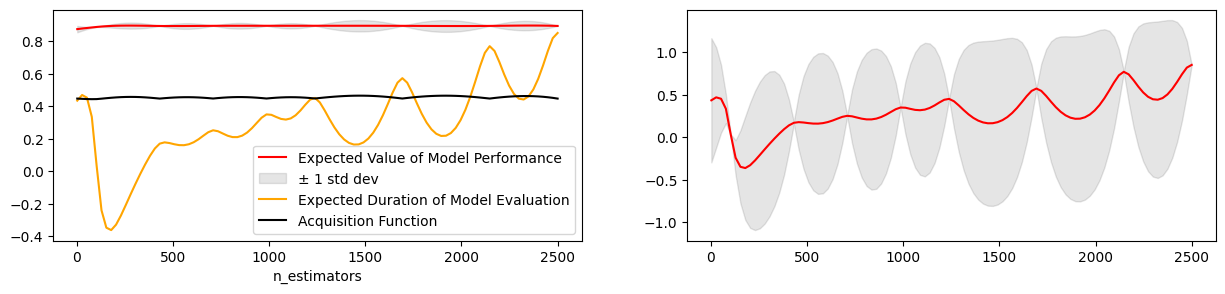

In [63]:
n_estimators_hp_range = (2, 2500)
grid_resolution = 100
n_estimators_grid = np.linspace(*n_estimators_hp_range, grid_resolution).reshape(-1, 1)

n_estimators_init = 100
n_estimators_attempts = []
n_estimators_performances = []
durations = []

kernel = Matern(length_scale=2.0, length_scale_bounds=n_estimators_hp_range)
performance_bayesian_optimizer = GaussianProcessRegressor(kernel=kernel)
duration_bayesian_optimizer = GaussianProcessRegressor(kernel=kernel)
explore_exploit = .5

for run_number in range(10):

    # init_case
    if run_number == 0:
        n_estimators = n_estimators_init
    else:
        grid_predicted_mean, grid_predicted_std = \
            performance_bayesian_optimizer.predict(n_estimators_grid, return_std=True)
        duration_predicted_mean, duration_predicted_std = \
            duration_bayesian_optimizer.predict(n_estimators_grid, return_std=True)
        acquisition_function = (explore_exploit * grid_predicted_mean + (1 - explore_exploit) * grid_predicted_std)  # / duration_predicted_mean
        next_best_n_estimators = n_estimators_grid[acquisition_function.argmax()]
        n_estimators = int(next_best_n_estimators)
        plot_prediction_surface(
            n_estimators_grid,
            grid_predicted_mean,
            grid_predicted_std,
            duration_predicted_mean,
            duration_predicted_std,
            acquisition_function,
        )
    
    # predict
    t_start = time.time()
    model = (
        LGBMRegressor(
            n_estimators=n_estimators,
            force_col_wise=True,
            verbosity=0,
        )
        .fit(
            X_train.select(MODEL_FEATURE_LIST),
            y_train.select(MODEL_TARGET).to_series()
        )
    )
    y_predicted = model.predict(X_test.select(MODEL_FEATURE_LIST))
    model_performance = 1 - root_mean_squared_error(y_test.select(MODEL_TARGET).to_series(), y_predicted)
    t_end = time.time()
    duration = t_end - t_start
    ln_duration = duration
    
    # fit bayesian optimizer
    n_estimators_attempts.append([n_estimators])
    n_estimators_performances.append(model_performance)
    durations.append(ln_duration)
    performance_bayesian_optimizer.fit(n_estimators_attempts, n_estimators_performances)
    duration_bayesian_optimizer.fit(n_estimators_attempts, durations)

In [62]:
np.log(1)

0.0

/var/folders/mp/m_zk6npd02n2mk4p8vt135480000gn/T/ipykernel_5497/3893955242.py:2: RuntimeWarning: invalid value encountered in log
  y = np.log(x)


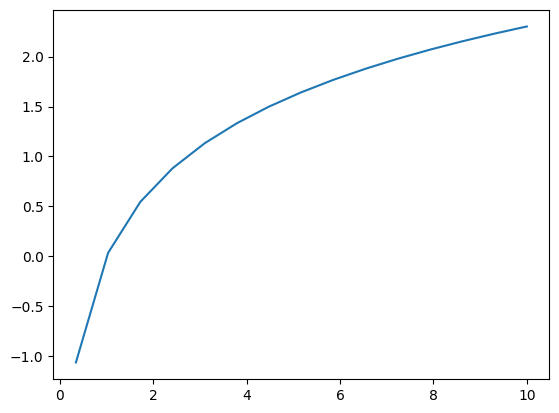

In [61]:
x = np.linspace(-10, 10, 30)
y = np.log(1)
plt.plot(x, y)